# ODE discovery Pendulum

## Imports

In [1]:
import numpy as np
import sys
sys.path.append('..')
from data.smoothing import smooth_pend
from data.pendulum import pendulum_train_data, pendulum_test_data
from data.pde_recovery import sample_idxs, load_and_shift_pend_data, optimal_recovery, rbf_vector_kernel
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'data.lin_smoothing'

## Generate and smooth data

In [61]:
# Perform the PDE learning step for the pendulum data

I = 20  # Number of pendulums we're running
results, f = pendulum_train_data(I=I, noise=0.01)
test_results, f_test = pendulum_test_data(I=50, noise=0.01, B=0.001)

sample = sample_idxs()
S_train, f_train, t_train = load_and_shift_pend_data(results, f, sample)
S_test, f_test, t_test = load_and_shift_pend_data(test_results, f_test, sample)

## Optimal recovery

In [62]:
def mse_loss(y_actual, y_pred, N_test):
    return (1/N_test)*np.linalg.norm(y_actual - y_pred, ord=2)**2

def rhs(u1, f, k=-9.81, l=.2):
    return -(k/l)*np.sin(u1)+f

In [46]:


# best_loss = 1000
# N = S_test.shape[-1]
# for l in np.linspace(0.0000001, 2000, 100):
#     for lam in np.linspace(1e-10, 1, 100):
#         loss = mse_loss(optimal_recovery(S_train[1,:, :2,:], rhs(S_train[0,:,0,:],f_train.T).T, S_test[1, :, :2,:], l, lam),rhs(S_test[0,:,0,:], f_test.T).T, N)
#         if loss < best_loss:
#             best_loss = loss
#             best_params = [l, lam]
# print(f"Best loss is {best_loss} with parameters {best_params}")

Best loss is 7.2714815688955206 with parameters [646.4646465323232, 1e-10]


In [63]:
# P_hat1_train = optimal_recovery(S_train[0], S_train[1, :, 0, :].T, S_train[0], .2) #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat1 = optimal_recovery(S_train[0, :, :,:], S_train[1, :, 0, :].T, S_test[0,:, :, :], 504, 0.0001)#P(u2(train)) = u1 u1(test) = P(u2(train))(test)


# P_hat2_train = optimal_recovery(S_train[1], rhs(results[:, 1, sample], f_train), S_train[1], .2) #P(u2(train)) = u1 u1(test) = P(u2(train))(test)

P_hat2 = optimal_recovery(S_train[1,:, :2,:], rhs(S_train[0,:,0,:],f_train.T).T, S_test[1, :, :2,:], 646.4646465323232, 1e-10) #P(rhs(train)) = u2  u2(test) = P(rhs(train)(test)

In [72]:
N = S_test.shape[-1]
mse = mse_loss(P_hat1, S_test[1, :, 0, :].T, N)
print(f"Mean squared error for u2 is {mse}")

Mean squared error for u2 is 0.022548555705803826


In [73]:
N = S_test.shape[-1]
print(f"Mean squared error for u2 is {mse_loss(P_hat2, rhs(S_test[0,:,0,:], f_test.T).T, N)}")

Mean squared error for u2 is 9.967952971566167


## Results

### $u_1(t)$ for training data

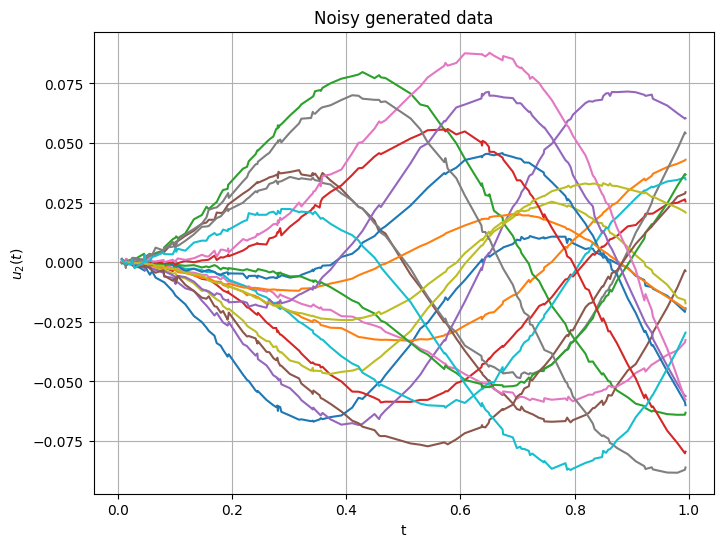

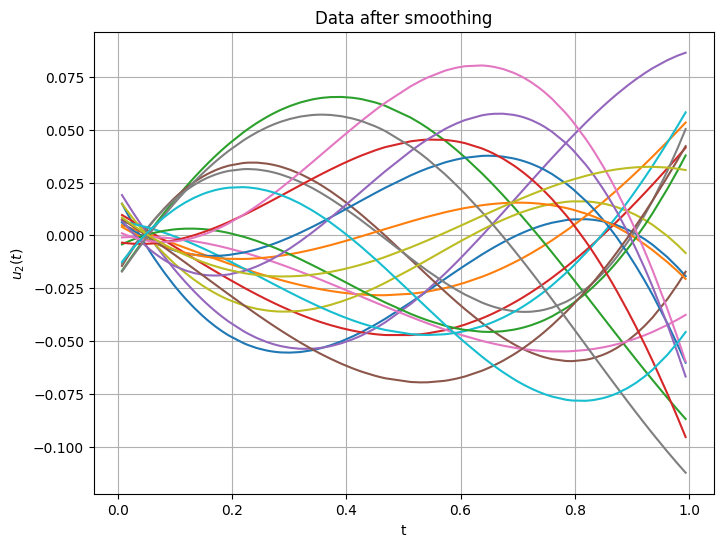

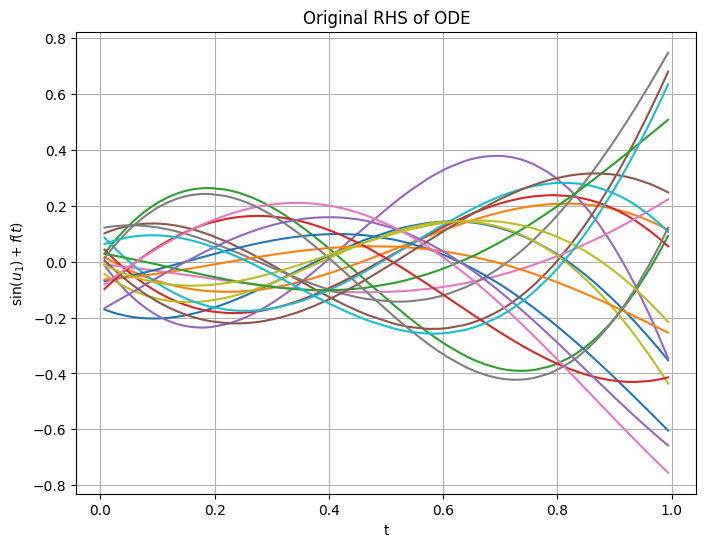

NameError: name 'P_hat1_train' is not defined

<Figure size 800x600 with 0 Axes>

In [13]:
# Results on the train set look quite smooth
plt.figure(figsize=(8, 6))

plt.plot(t_train, results[:, 0, sample].T) # u1_t
plt.xlabel('t')
plt.ylabel('$u_2(t)$')
plt.title('Noisy generated data')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, S_train[0, :, 0, :]) #u1_t
plt.xlabel('t')
plt.ylabel('$u_2(t)$')
plt.title('Data after smoothing')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, S_train[1, :, 0, :]) #u1_t
plt.xlabel('t')
plt.ylabel('$\sin(u_1) + f(t)$')
plt.title('Original RHS of ODE')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, P_hat1_train.T) #u1_t
plt.xlabel('t')
plt.ylabel('Functional estimator $\overline{\mathcal{P}}( x, u, u_{t}, u_{tt}, sin(u_1), sin(u_2))$')
plt.title("Functional estimator $\overline{\mathcal{P}}( x, u, u_{t}, u_{tt}, sin(u_1), sin(u_2))$")
plt.grid(True)
plt.show()


# plt.figure(figsize=(8, 6))

# plt.plot(t_train, rhs(P_hat1_train, f_train).T) # u1_t
# plt.xlabel('t')
# plt.ylabel('Function trajectory')
# plt.title('RHS from optimal recovery')
# plt.grid(True)
# plt.show()

### $u_2(t)$ on training data

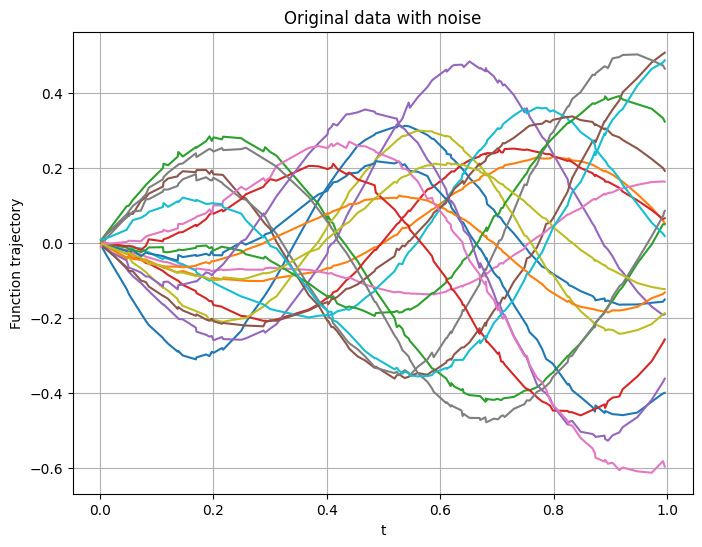

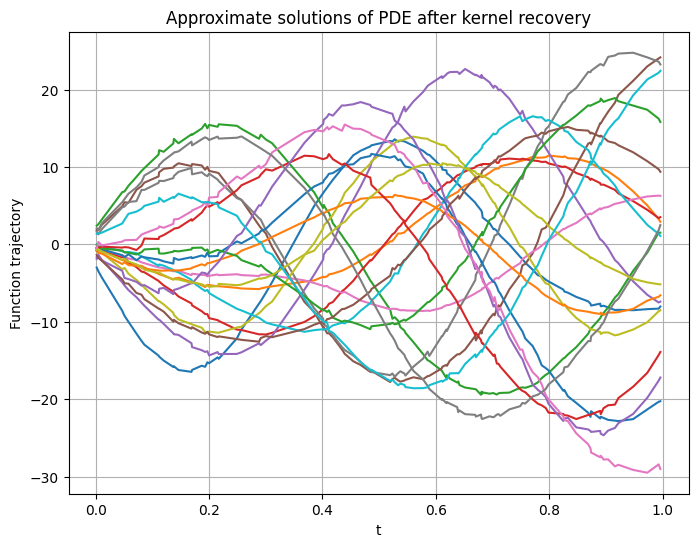

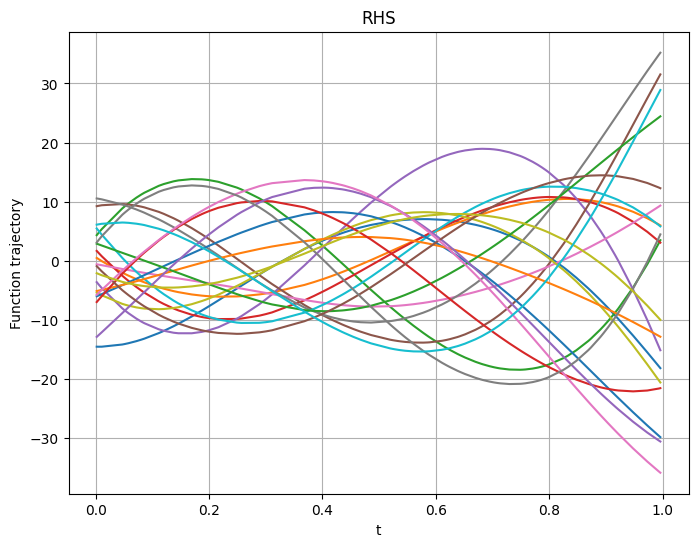

In [8]:
# Results on the train set look quite smooth
plt.figure(figsize=(8, 6))

plt.plot(t_train, results[:, 1, sample].T) # u2
plt.xlabel('t')
plt.ylabel('$u_2(t)$')
plt.title('Original data with noise')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, results[:, 1, sample].T) # u2
plt.xlabel('u_2(t)')
plt.ylabel('Function trajectory')
plt.title('Data after smoothing')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, P_hat2_train.T) # u1_t
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Approximate solutions of PDE after kernel recovery')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_train, rhs(P_hat1_train, f_train).T) # u1 
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('RHS')
plt.grid(True)
plt.show()

### $u_1$ on testing data

In [28]:
S_test[1,:,0].shape

(95, 50)

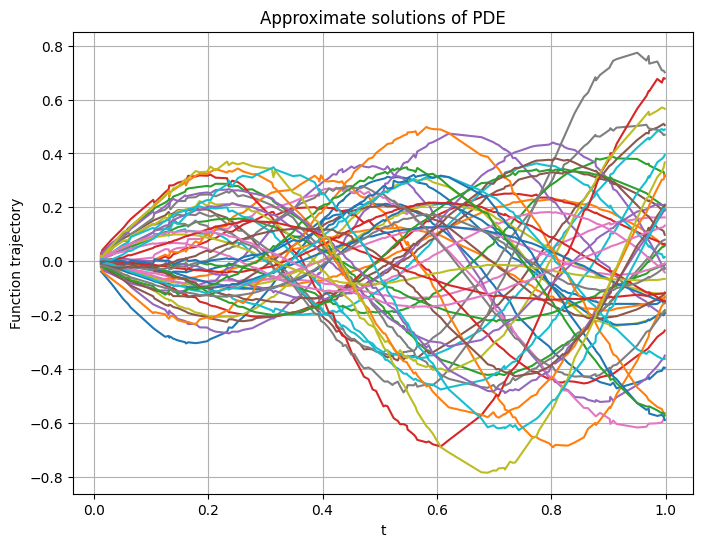

(2, 109, 5, 50)


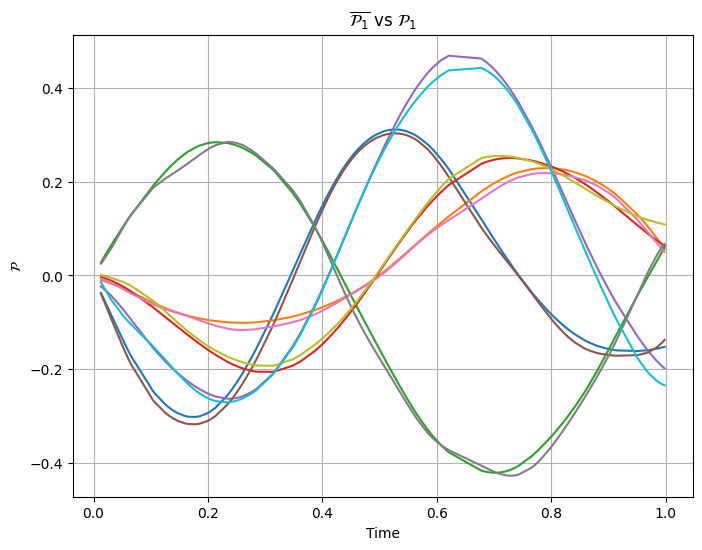

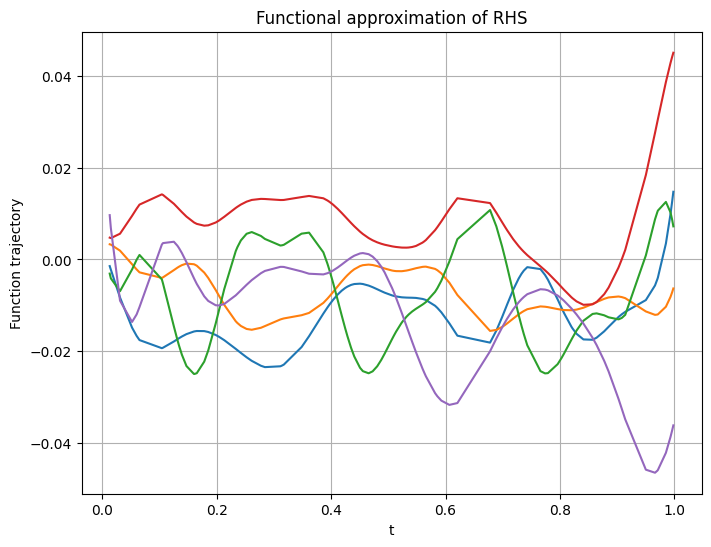

In [80]:
plt.figure(figsize=(8, 6))

plt.plot(t_test, test_results[:, 1, sample].T)
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Approximate solutions of PDE')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

print(S_test.shape)
plt.plot(t_test, S_test[1, :, 0, :5])
plt.xlabel('t')
plt.ylabel('$\mathcal{P}$')
plt.title('RHS of $u_1$')
plt.grid(True)
# plt.show()

# plt.figure(figsize=(8, 6))

plt.plot(t_test, P_hat1.T[:,:5]) # u2
plt.xlabel('Time')
# plt.ylabel('$u_1(t)$')
plt.title('$\overline{\mathcal{P}_1}$ vs $\mathcal{P}_1$')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_test, ((P_hat1.T[:,:5] - (S_test[1, :, 0, :5])))) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('Functional approximation of RHS')
plt.grid(True)
plt.show()


### $u_2$ on testing data

In [28]:
# Plot the differences of the RHS of pendulum eqn and p_hat, the estimator
S_test.shape
P_hat2.T.shape

(104, 50)

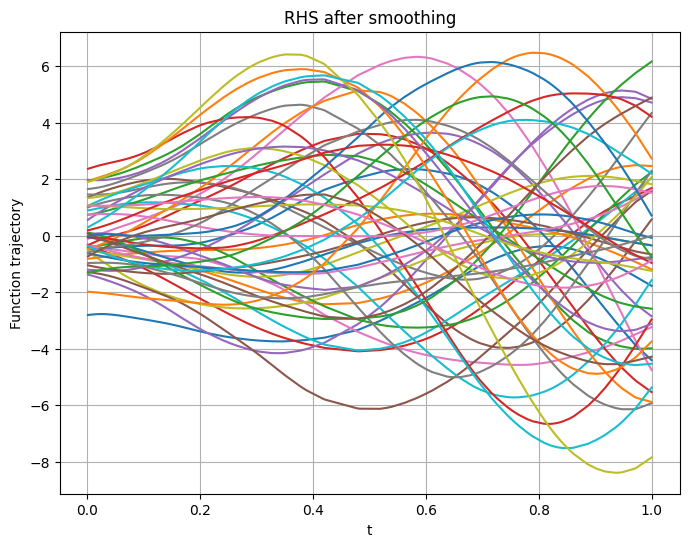

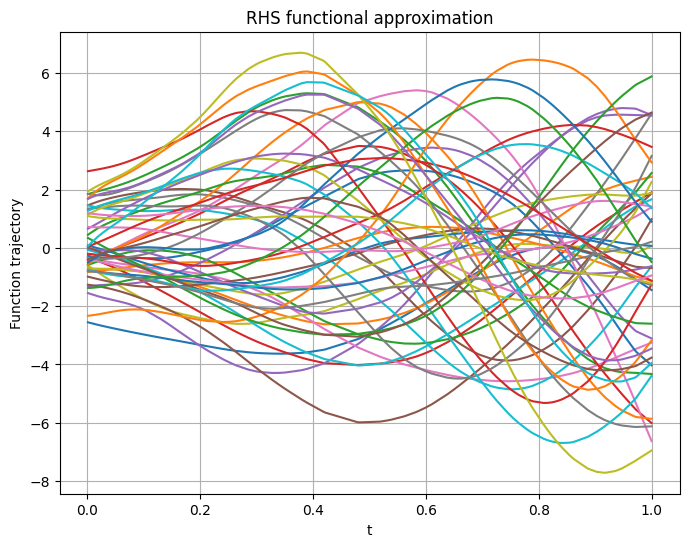

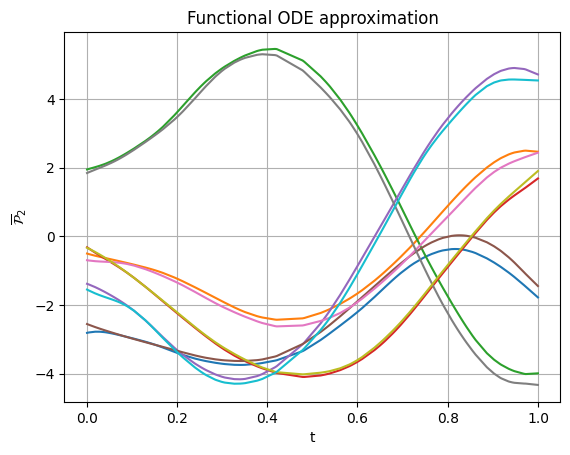

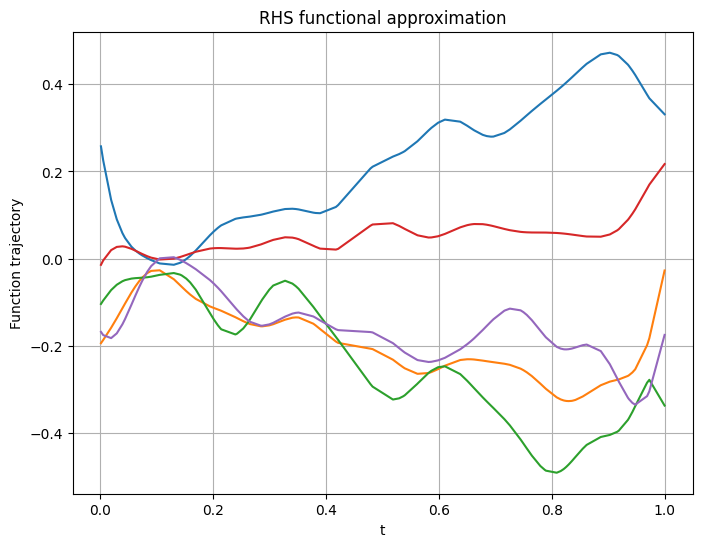

In [69]:
# plt.figure(figsize=(8, 6))

# plt.plot(t_test, rhs(test_results[:, 1, sample], f_test).T)
# plt.xlabel('t')
# plt.ylabel('Function trajectory')
# plt.title('$u_2$ before smoothing')
# plt.grid(True)
# plt.show()

plt.figure(figsize=(8, 6))

plt.plot(t_test, (rhs(S_test[0,:,0,:], f_test.T)))
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('RHS after smoothing')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t_test, P_hat2.T) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('RHS functional approximation')
plt.grid(True)
plt.show()


plt.plot(t_test, (rhs(S_test[0,:,0,:], f_test.T))[:,:5])
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('RHS after smoothing')
plt.grid(True)

plt.plot(t_test, P_hat2.T[:,:5]) # u2
plt.xlabel('t')
plt.ylabel('$\overline{\mathcal{P}}_2$')
plt.title('Functional ODE approximation')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(t_test, (P_hat2.T - rhs(S_test[0,:,0,:], f_test.T))[:, :5]) # u2
plt.xlabel('t')
plt.ylabel('Function trajectory')
plt.title('RHS functional approximation')
plt.grid(True)
plt.show()
